# Car accident severity predictor

This is the project report by Katharina Egert, submitted October 2020.

## 1. Introduction

The objective of this project is to create a way to predict severity of car accidents happening based on road and weather conditions.
That is, our algorithm needs to take as input the conditions that may impact severity of accidents:

* road conditions
* weather conditions
* lighting conditions

etc.

and predict the risk profile of potential accidents, i.e. the severity label. A user should then be able to specify the current conditions
of their itinerary and should then get back the severity label of accidents happening.

Example: A wet road should potential lead to higher severity accidents than a dry road.

The main stakeholders are:

* __traffic regulators__: They can make policies (e.g. speed limits, higher controls etc) in order to mitigate risks.
* __drivers__: They can recognize risks in advance and adapt their behavior in order to lower their own personal risks, e.g. drive more carefully or even avoid travelling at at risk conditions all together.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



## 2. Data 

In this section we will descibe the underlying data.

### 2.1 Data Source

The given data set contains all collisions provided by Seattle police departement and recorded by Traffic Records. The level of aggregation is
weekly. The timeframe is 2004 to today.
(See metadata from the SPD Collision data set.)

### 2.2 Data Loading
In the next step, we load the data into the notebook and display the first 5 lines of the raw table. Not all columns will be used and some will need to be transformed in order to be exploitable for our later classification.

In [2]:
full_df = pd.read_csv("../Data-Collisions.csv", low_memory=False)
full_df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### 2.3 Data Description

The problem consists in predicting accident severity based on outer conditions of accidents recorded. 
The label to be predicted is 'SEVERITYCODE'. A description of the severity is contained in the column 'SEVERITYDESC' and 'SEVERITYCODE.1'
which is therefore redundant.



The following columns are of a technical nature and therefore of no use to us:

* 'OBJECTID',
* 'INCKEY', 
* 'COLDETKEY', 
* 'REPORTNO',
* 'STATUS'
* 'INTKEY'
* 'EXCEPTRSNCODE',
* 'EXCEPTRSNDESC'

There are several other fields in the data set such as 'UNDER_INF' (influenced by alcohol/drug use) which might be good predictors for severity, however it does not make sense to use these for this problem as traffic planers as well as drivers (apart from their own sobriety) will not be able to input this data when using this analysis. The same goes for pedestrian/cyclist count (which is actually depending on the dependent variable!) as one will not know how many pedestrians/bikes will be on the road on a given day. 

The total list of colums concerned is:
* 'PERSONCOUNT', 
* 'PEDCOUNT', 
* 'PEDCYLCOUNT', 
* 'VEHCOUNT',
* 'INATTENTIONIND',
* 'UNDERINFL',
* 'HITPARKEDCAR',
* 'SPEEDING',
* 'HITPARKEDCAR',
* 'PEDROWNOTGRNT',
* 'SDOTCOLNUM', 
* 'ST_COLCODE', 
* 'ST_COLDESC',
* 'SEGLANEKEY', 
* 'CROSSWALKKEY',
* 'SDOT_COLCODE'
* 'SDOT_COLDESC',
* 'COLLISIONTYPE',

The colums that can be explored are
* 'ADDRTYPE', 'X', 'Y'
* 'LOCATION',
* 'INCDATE' and 'INCDTTM',
* 'JUNCTIONTYPE',
* 'WEATHER'
* 'ROADCOND', 
* 'LIGHTCOND'
       
  



# 3. Methodology
This section represents the main component of the report where I will discuss and describe exploratory data analysis and inferential statistical testing performed.


### 3.1 Label analysis
We need to predict severity of the accident given by the data colum 'SEVERITYCODE'. The following codes are given:

* 3—fatality 
* 2b—serious injury
* __2—injury__
* __1—property damage__
* 0—unknown

Only labels of 1 and 2 are present in the dataset. 

We will now analyze the frequency of their occurrences. The first static gives the absolute frequency, the second one the relative frequency.

In [3]:
full_df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [4]:
full_df['SEVERITYCODE'].value_counts().apply(lambda r: r/full_df['SEVERITYCODE'].count())

1    0.701099
2    0.298901
Name: SEVERITYCODE, dtype: float64

It turns out that property damage appears more than twice as often as injuries. This means that out data set is unbalanced, hence we need to try later on to account for this imbalance.

Secondly, for the algorithm to make sense from the stake holder point of view, it is much more important to detect the risk of potential injury-type accidents than misclassifiying an actual property damage case, since one is rather too careful than take too much risk. This will help us shape the cost function.


###  3.2 Feature selection

In this section, we will select the features which determine the features to use. For this we will first use business knowledge to select obvious factors and then also check which column seems to have the most impact on the severity outcome. 

* 'WEATHER' containing data on the weather such at if it was dry or wet etc.
* 'ROADCOND' containing information whether the road was dry, wet etc.
* 'LIGHTCOND' containing data on lighting, e.g. if it was dark.

We will check for these three first and eliminate unusable columns.

<!--

 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING',

Full colums
SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'-->
       
#### 'WEATHER'

We first check for the values.

In [5]:
full_df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

Now we're interested to see which of these conditions correlate with higher rates of injuries (e.g. higher than 23% -- the globale average)

In [6]:
pd.crosstab(full_df['WEATHER'],full_df['SEVERITYCODE']).apply(lambda r: np.round(r/r.sum(),decimals=3), axis=1).sort_values(by = [2])

SEVERITYCODE,1,2
WEATHER,,
Unknown,0.946,0.054
Other,0.861,0.139
Snowing,0.811,0.189
Sleet/Hail/Freezing Rain,0.752,0.248
Blowing Sand/Dirt,0.732,0.268
Severe Crosswind,0.720,0.280
Overcast,0.684,0.316
Clear,0.678,0.322
Fog/Smog/Smoke,0.671,0.329


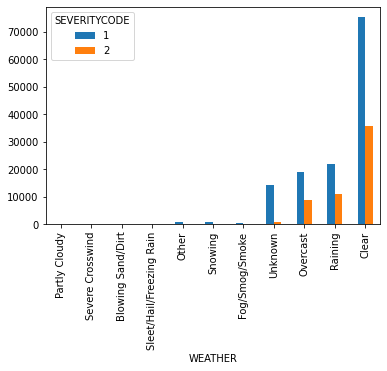

In [7]:
pd.crosstab(full_df['WEATHER'],full_df['SEVERITYCODE']).sort_values(by = [2]).plot(kind="bar")
plt.savefig('foo.png')

__Observations:__

1. Unknown and other make up for the smalles percentages of injuries.
1. Snowing, while intuitively making up for a big risk, has actually a lower risk than the globale average (19% instead of 23%) Perhaps drivers are already taking this risk into account and drive more carefully.
1. Nice weather, e.g. 'Clear', 'Overcast' or 'Partly Cloudy' still accounts for a more than average amount of injuries. Note that the class 'Partly Cloudy' is very small (n=5), so it's high injury rate is not significant.
1. Raining is the most dangerous condition.


The category 'Unknown' and 'Other' does not lead to any further information, so we will remove these rows as well as missing data rows.

In [8]:
df = full_df[ (full_df['WEATHER']!= "Unknown") & (full_df['WEATHER']!= "Other")]
df = df.dropna(subset=['SEVERITYCODE','WEATHER'])

We will use our domain knowledge and group some of the weather conditions together, so that the classes become sufficiently big to be statiscally exploitable.

This leaves us with the following relative frequency.

In [9]:
df['SEVERITYCODE'].value_counts().apply(lambda r: r/df['SEVERITYCODE'].count())

1    0.676557
2    0.323443
Name: SEVERITYCODE, dtype: float64

In [10]:
weather_dict = {'Clear': 'mild','Overcast':'mild','Partly Cloudy':'mild', \
                'Snowing' : 'snowing', \
                'Sleet/Hail/Freezing Rain': 'sleet/hail/freezing rain', \
                'Blowing Sand/Dirt': 'windy',  'Severe Crosswind': 'windy', \
                'Raining': 'raining'
               }
df['WEATHER'] = df['WEATHER'].map(weather_dict)
df['WEATHER'].value_counts()


mild                        138854
raining                      33145
snowing                        907
sleet/hail/freezing rain       113
windy                           81
Name: WEATHER, dtype: int64

In [11]:
pd.crosstab(df['WEATHER'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [2])

SEVERITYCODE,1,2
WEATHER,,
snowing,0.811466,0.188534
sleet/hail/freezing rain,0.752212,0.247788
windy,0.728395,0.271605
mild,0.678886,0.321114
raining,0.662815,0.337185


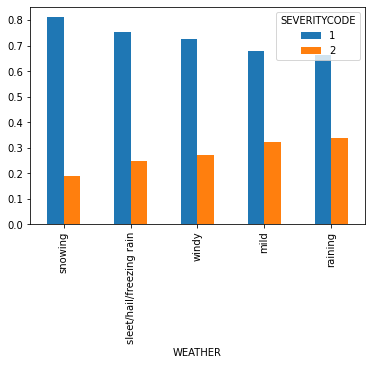

In [12]:
pd.crosstab(df['WEATHER'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [2]).plot(kind='bar')

### 'ROADCOND'

We do the exact same thing for road conditions. We'll start with frequency.

In [13]:
df['ROADCOND'].value_counts()

Dry               123402
Wet                46956
Ice                 1113
Unknown              919
Snow/Slush           902
Other                108
Standing Water       108
Sand/Mud/Dirt         65
Oil                   60
Name: ROADCOND, dtype: int64

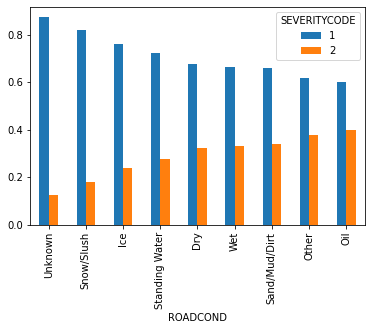

In [14]:
pd.crosstab(df['ROADCOND'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [2]).plot(kind='bar')

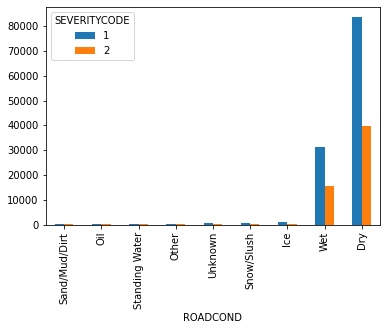

In [15]:
pd.crosstab(df['ROADCOND'],df['SEVERITYCODE']).sort_values(by = [2]).plot(kind='bar')

__Observations__

1. Unknown/Other are again categories without information which we can eliminate.
1. Snow/Slush and Ice are again surprisingly, low risk.
1. Oil and Wet yield slippery conditions and are therefore high risk as one would guess.

In [16]:
df = df[ (df['ROADCOND']!= "Unknown") & (df['ROADCOND']!= "Other")]
df = df.dropna(subset=['ROADCOND'])

After elimination of these columns, we have the following average severities.

In [17]:
df['SEVERITYCODE'].value_counts().apply(lambda r: r/df['SEVERITYCODE'].count())

1    0.675539
2    0.324461
Name: SEVERITYCODE, dtype: float64

### 'LIGHTCOND'

We do the exact same thing for light conditions. We'll start with frequency.

In [18]:
df['LIGHTCOND'].value_counts()

Daylight                    112618
Dark - Street Lights On      46748
Dusk                          5648
Dawn                          2413
Unknown                       2305
Dark - No Street Lights       1408
Dark - Street Lights Off      1114
Other                          185
Dark - Unknown Lighting          8
Name: LIGHTCOND, dtype: int64

In [19]:
pd.crosstab(df['LIGHTCOND'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [2])

SEVERITYCODE,1,2
LIGHTCOND,,
Unknown,0.897180,0.102820
Dark - No Street Lights,0.771307,0.228693
Other,0.745946,0.254054
Dark - Street Lights Off,0.722621,0.277379
Dark - Street Lights On,0.694896,0.305104
Dawn,0.665976,0.334024
Dusk,0.663598,0.336402
Daylight,0.661866,0.338134
Dark - Unknown Lighting,0.625000,0.375000


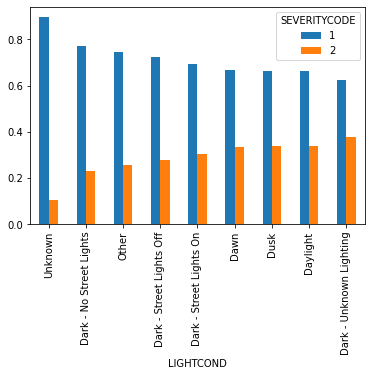

In [20]:
pd.crosstab(df['LIGHTCOND'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [2]).plot(kind='bar')

__Observations:__

1. Our domain knowledge tells us, the darker the more risky.
1. Most accidents happen at daylight, so lighting does not fully explain higher severity accidents.
1. Domain: Dusk/dawn are similar, also no streetlights when dark, so we can group these together.

We drop again 'Unknown', 'Other', 'Dark - Unknown Lighting' and missing values.


In [21]:
df = df[ (df['LIGHTCOND']!= "Unknown") & (df['LIGHTCOND']!= "Other") & (df['LIGHTCOND'] != "Dark - Unknown Lighting")]
df = df.dropna(subset=['LIGHTCOND'])

In [22]:
df['SEVERITYCODE'].value_counts().apply(lambda r: r/df['SEVERITYCODE'].sum())

1    0.506446
2    0.246777
Name: SEVERITYCODE, dtype: float64

In [23]:
light_dict = {'Dark - No Street Lights' : 'dark - no lights', 'Dark - Street Lights Off': 'dark - no lights', \
              'Dark - Street Lights On' : 'dark with lights', \
              'Dawn': 'dusk/dawn', 'Dusk': 'dusk/dawn', \
              'Daylight': 'daylight'\
               }
df['LIGHTCOND'] = df['LIGHTCOND'].map(light_dict)
df['LIGHTCOND'].value_counts()

daylight            112618
dark with lights     46748
dusk/dawn             8061
dark - no lights      2522
Name: LIGHTCOND, dtype: int64

In [24]:
pd.crosstab(df['LIGHTCOND'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [2])

SEVERITYCODE,1,2
LIGHTCOND,,
dark - no lights,0.749802,0.250198
dark with lights,0.694896,0.305104
dusk/dawn,0.664310,0.335690
daylight,0.661866,0.338134


### Time dimension

We do get a timing dimension via 'INCDTTM'. First, we need to cast this column as datetime.

In [25]:
df['INCDTTM'].head()
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
df['INCDTTM'].head()

0   2013-03-27 14:54:00
1   2006-12-20 18:55:00
2   2004-11-18 10:20:00
3   2013-03-29 09:26:00
4   2004-01-28 08:04:00
Name: INCDTTM, dtype: datetime64[ns]

Next, we extract dates (for our time series), extract the hour as well as the weekday.

In [26]:
df['date'] = df['INCDTTM'].dt.date
df['hour'] = df['INCDTTM'].dt.hour
df['weekdaynum'] = df['INCDTTM'].dt.weekday

dict_weekday = {0 : 'Monday', 1: 'Tuesday', \
                2 : 'Wednesday',  3 : 'Thursday',\
                4 : 'Friday',  5 : 'Saturday', 6 : 'Sunday'
               }
df['weekday'] = df['weekdaynum'].map(dict_weekday)

#### Dates


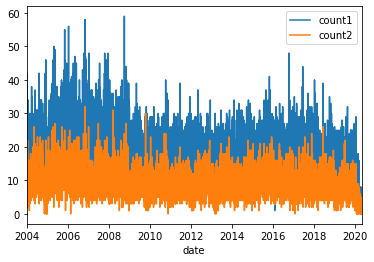

In [27]:
df['count1'] = df['SEVERITYCODE'].apply(lambda x: 1 if (x == 1) else 0)
df['count2'] = df['SEVERITYCODE'].apply(lambda x: 1 if (x == 2) else 0)

ts = df[['date','count1','count2']].groupby(['date']).sum()
ts.plot()

__Observations__
1. We see a steady decline. Therefore it might make sense to introduce a per year variable.  
1. Additionally, there seems to be a by month seasonality.

In [28]:
df['year'] = df['INCDTTM'].dt.year
df['month'] = df['INCDTTM'].dt.month

#### Years

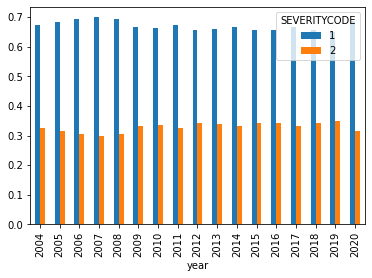

In [29]:
pd.crosstab(df['year'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar')

In [30]:
pd.crosstab(df['year'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)

SEVERITYCODE,1,2
year,,
2004,0.673354,0.326646
2005,0.685045,0.314955
2006,0.694734,0.305266
2007,0.699609,0.300391
2008,0.693977,0.306023
2009,0.666869,0.333131
2010,0.664574,0.335426
2011,0.674935,0.325065
2012,0.657352,0.342648


#### Month

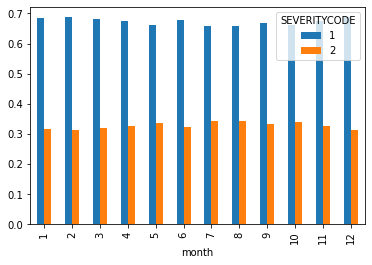

In [31]:
pd.crosstab(df['month'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar')

In [32]:
pd.crosstab(df['month'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)

SEVERITYCODE,1,2
month,,
1,0.684810,0.315190
2,0.688054,0.311946
3,0.680452,0.319548
4,0.674265,0.325735
5,0.662940,0.337060
6,0.676699,0.323301
7,0.657716,0.342284
8,0.658525,0.341475
9,0.668089,0.331911


Here we see a seasonality trend for winter and summer. So it suffices to use these as indicator variables.

In [33]:
df['is_summer'] = df['month'].apply(lambda x: 1 if (x == 7) or (x== 8)  else 0)
df['is_winter'] = df['month'].apply(lambda x: 1 if (x <= 3) or (x== 12)  else 0)


#### Hour

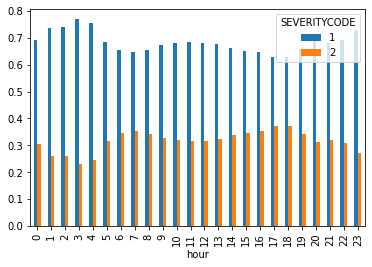

In [34]:
pd.crosstab(df['hour'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar')

__Observations:__

1. There is a dip betyeen 1 and 4am.
1. The peak is around 5pm.
1. The relationship is not linear, hence we cannot use it as a standard numerical variable.

In [35]:
df['time'] = df['hour'].apply(lambda x: \
                                     'night' if ( ((x >= 1) & (x <= 4)) or (x>= 20)) else \
                                     ('midnight' if (x == 0)  else \
                                     ('rushhour' if ( ((x >= 5) & (x <= 9)) or ((x >= 15) & (x <= 19))) else\
                                     'day')))

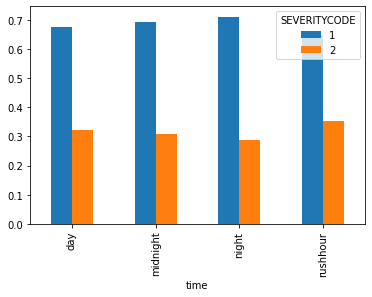

In [36]:
pd.crosstab(df['time'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar')

#### Weekday

In [37]:
pd.crosstab(df['weekday'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by=[2])#.plot(kind='bar')

SEVERITYCODE,1,2
weekday,,
Sunday,0.694246,0.305754
Saturday,0.678400,0.321600
Friday,0.676581,0.323419
Wednesday,0.667567,0.332433
Tuesday,0.665932,0.334068
Monday,0.665849,0.334151
Thursday,0.662643,0.337357


__Obervations:__

1. Sunday is the safest day.
1. All other weekdays are pretty much equal.

We can therefore create a boolean type (cast as number for later algorithms) to simplify this feature.

In [38]:
df['is_sunday'] = df['weekday'].apply(lambda x: 1 if (x == "Sunday") else 0)

In [39]:
pd.crosstab(df['is_sunday'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by=[2])#.plot(kind='bar')

SEVERITYCODE,1,2
is_sunday,,
1,0.694246,0.305754
0,0.669611,0.330389


### Location type

As a driver, one knows that accidents are more likely at intersections. This information is stored in the variable 'ADDRTYPE'. 

In [40]:
df['ADDRTYPE'].value_counts()

Block           107379
Intersection     61267
Alley              593
Name: ADDRTYPE, dtype: int64

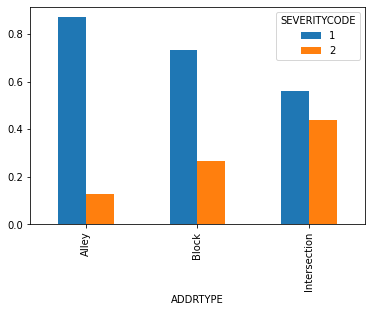

In [41]:
pd.crosstab(df['ADDRTYPE'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1).sort_values(by=[2]).plot(kind='bar')

#### Feature summary

We will therefore use

* WEATHER (transformed)
* ROADCOND
* LIGHTCOND (transformed)
* time_of_day (transformed from date)
* is_sunday (transformed from date)
* is_summer and is_winter (transformed from date)
* ADDRTYPE 


We therefore reduce the columns as follows:

In [42]:
df = df[['SEVERITYCODE','WEATHER','ROADCOND','LIGHTCOND','time', 'is_sunday', 'ADDRTYPE','year','is_summer','is_winter']]
df.head()

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND,time,is_sunday,ADDRTYPE,year,is_summer,is_winter
0,2,mild,Wet,daylight,day,0,Intersection,2013,0,1
1,1,raining,Wet,dark with lights,rushhour,0,Block,2006,0,1
2,1,mild,Dry,daylight,day,0,Block,2004,0,0
3,1,mild,Dry,daylight,rushhour,0,Block,2013,0,1
4,2,raining,Wet,daylight,rushhour,0,Intersection,2004,0,1


First we convert the categorical data into dummy variables encoding our categorical variables.

In [43]:
dummy_columns = ['WEATHER','ROADCOND','LIGHTCOND','ADDRTYPE','time','year','is_summer','is_winter']
data = pd.get_dummies(df,columns=dummy_columns)
data.head()

,SEVERITYCODE,is_sunday,WEATHER_mild,WEATHER_raining,WEATHER_sleet/hail/freezing rain,WEATHER_snowing,WEATHER_windy,ROADCOND_Dry,ROADCOND_Ice,ROADCOND_Oil,...,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,is_summer_0,is_summer_1,is_winter_0,is_winter_1
0,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


### Correlation analysis

We will do an analyis of correlations to check which columns have the biggest impact using the Pearson index. Values close to -1 and 1 indicate strong (anti-) correlation.      

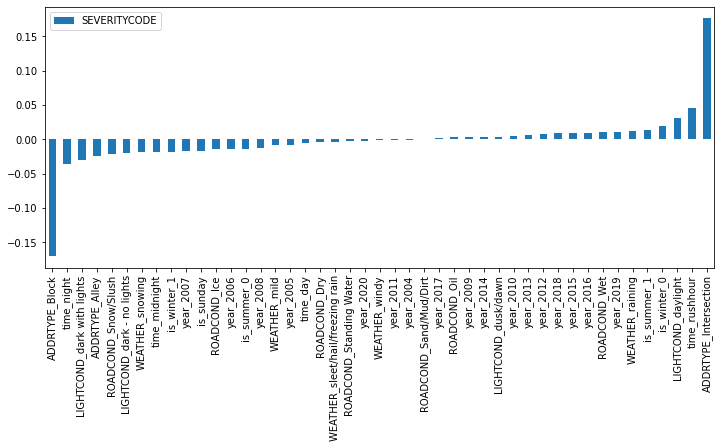

In [44]:
corr = data.corr(method='pearson').drop('SEVERITYCODE')
corr[['SEVERITYCODE']].sort_values(by = 'SEVERITYCODE').plot(kind='bar', figsize= [12, 4.8])

### 3.3 Machine learning models

We will try several variants of machine learning models.

* Logistic Regression
* Random Forests


In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 3.3.1 Creating Balance

First of all, we need to find a way to deal with the imbalanced-ness of data. This can be handled via weights for logistic regression reflecting the frequency of occurrence.

In [46]:
weight1 = len(data) / (len(data[data['SEVERITYCODE'] == 1])*2)
weight2 = len(data) / (len(data[data['SEVERITYCODE'] == 2])*2)#*1.2#*1.31
print("Weight1: " + str(weight1))
print("Weight2: " + str(weight2))
weights = {1:weight1, 2:weight2}

Weight1: 0.7436356317111378
Weight2: 1.526122485632184


#### 3.3.2 Train-test-split

Secondly, we need to split the data into a train and test set.

In [47]:
X = data.drop('SEVERITYCODE', axis=1).values
#X = preprocessing.StandardScaler().fit(X).transform(X)
y = data['SEVERITYCODE']

In [48]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=10)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (135959, 45) (135959,)
Test set: (33990, 45) (33990,)


#### 3.3.3 Logistic Regression

Here, we model the probability of a feature set to result in either category. This algorithm is designed for binary decision problems, which is the case for this data set and the posed question.

__Model tuning__ We tune model performance by testing several hyperparameters using RandomizedSearchCV.


In [49]:
reg_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
}


randomized_cv = RandomizedSearchCV(
    LogisticRegression(class_weight=weights),
    param_distributions=reg_params,
    cv=3,
    scoring='f1',
    verbose=5,
    n_jobs=-1,
    random_state=0
)

randomized_cv.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0,
          class_weight={1: 0.7436356317111378, 2: 1.526122485632184},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04]), 'solver': ['liblinear']},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='f1', verbose=5)

In [50]:
y_hat_lg = randomized_cv.predict(X_test)
print("Classification Report: Logistic Regression")
print(classification_report(y_test, y_hat_lg))
print("Accuracy: " + str(round(metrics.accuracy_score(y_test, y_hat_lg, normalize=True)*100,2)) + "% (correctly classified test data)")
print("F1: " + str(round(metrics.f1_score(y_test, y_hat_lg),6))+ " (weighted average of recall and precision)")


Classification Report: Logistic Regression
              precision    recall  f1-score   support

           1       0.73      0.70      0.71     22890
           2       0.43      0.48      0.45     11100

   micro avg       0.62      0.62      0.62     33990
   macro avg       0.58      0.59      0.58     33990
weighted avg       0.63      0.62      0.63     33990

Accuracy: 62.46% (correctly classified test data)
F1: 0.714375 (weighted average of recall and precision)


Confusion matrix, without normalization
[[15957  6933]
 [ 5827  5273]]


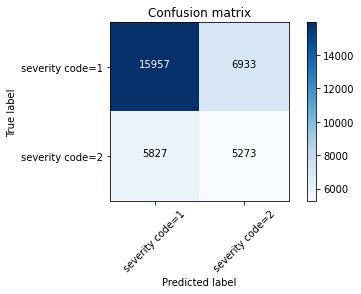

In [51]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_lg, labels=[1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['severity code=1','severity code=2'],normalize= False,  title='Confusion matrix')

#### 3.3.4 Random Forests

Random forests are a good candidate because they are very versatile and will allow us to work with out categorical data.

In [52]:
rf_params = {
    'max_depth': [2, 5, 10, 20],
    'max_features': [5, 7, 10, 15],
    'n_estimators': [100, 200, 500, 700],
    'min_samples_split': [10, 15, 20]
}

randomized_cv = RandomizedSearchCV(
    RandomForestClassifier(class_weight=weights),
    param_distributions=rf_params,
    cv=3,
    scoring='f1',
    verbose=5,
    n_jobs=-1,
    random_state=0
)

randomized_cv.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={1: 0.7436356317111378, 2: 1.526122485632184},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [2, 5, 10, 20], 'max_features': [5, 7, 10, 15], 'n_estimators': [100, 200, 500, 700], 'min_samples_split': [10, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='f1', verbose=5)

We can then extract the best model and fit the data.

In [53]:
RF = randomized_cv.estimator
RF.fit(X_train, y_train)

/Users/Katie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True,
            class_weight={1: 0.7436356317111378, 2: 1.526122485632184},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [54]:
y_hat_rf = randomized_cv.predict(X_test)
print("Classification Report: Random Forest")
print(classification_report(y_test, y_hat_rf))
print("Accuracy: " + str(round(metrics.accuracy_score(y_test, y_hat_rf, normalize=True)*100,2)) + "% (correctly classified test data)")
print("F1: " + str(round(metrics.f1_score(y_test, y_hat_rf),6)) + " (weighted average of recall and precision)")


Classification Report: Random Forest
              precision    recall  f1-score   support

           1       0.73      0.70      0.71     22890
           2       0.43      0.48      0.45     11100

   micro avg       0.62      0.62      0.62     33990
   macro avg       0.58      0.59      0.58     33990
weighted avg       0.63      0.62      0.63     33990

Accuracy: 62.47% (correctly classified test data)
F1: 0.714462 (weighted average of recall and precision)


So, random forests beat logistic regression in the F1-score by a very slight margin.

#### 3.3.5 Importances Analysis

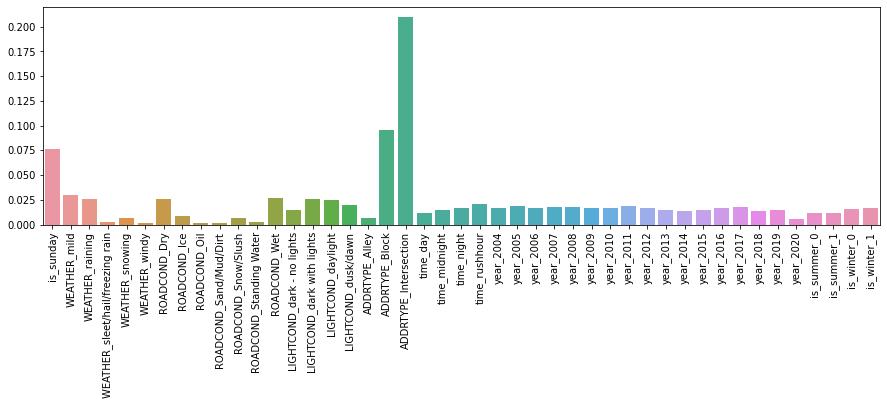

In [55]:
importances = [abs(i) for i in RF.feature_importances_]
data.drop('SEVERITYCODE', axis=1).columns.values
ax = sns.barplot(data.drop('SEVERITYCODE', axis=1).columns.values, importances)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.figure.set_figwidth(15)

## 4. Results
Out of our two approaches, logistic classification and random forests, we pick random foreces because of the better f1 score performance.
We summarize it's statisics.

Confusion matrix, without normalization
[[15960  6930]
 [ 5827  5273]]


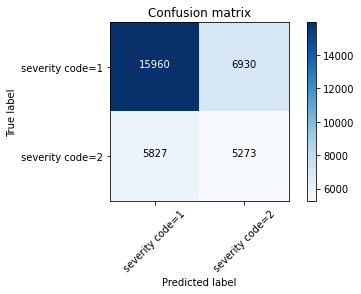

In [56]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_rf, labels=[1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['severity code=1','severity code=2'],normalize= False,  title='Confusion matrix')

Based on our model, we can extract the following importances of the features importances.

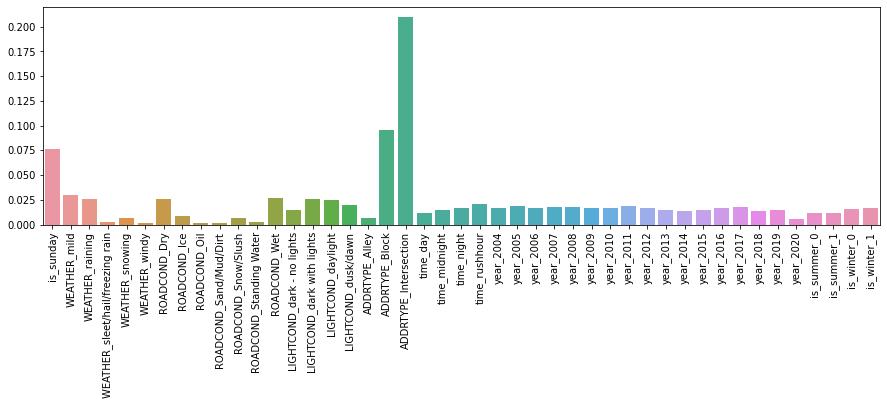

In [57]:
importances = [abs(i) for i in RF.feature_importances_]
data.drop('SEVERITYCODE', axis=1).columns.values
ax = sns.barplot(data.drop('SEVERITYCODE', axis=1).columns.values, importances)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.figure.set_figwidth(15)

We note that __address type: intersection__, __address type: block__ and the fact that it is __sunday__ play the most dominant roles.


## 5. Discussion
Our models work acceptably well to recognize code 1 accidents, however the recall is low for code 2 accidents. One path of improvement could be to increase the weight for code 2 accidents, since misclassifying them (e.g. underestimating an injury-type accident) is more 'costly' for drivers.

The most striking feature we notice in the feature importance analysis is the importance of intersections. They pose a major risk for injuries in accident.


## 6. Conclusion

In this analysis, we have analyzed the question of what impacts accident severity based on the overall conditions the driver is
facing. We have used as basis the data collected by the Seattle police departement from 2004 to today. We have conducted
a data analysis and selected features that had most impact on the accident severity.

As predictive models, we have used logistic regression and random forests, both leading to similar accuracy values with
random forests having a small advantage. Both models suffer from lower recall for type 2 classifications. In a future analyis,
this may be mitigated by using different weights.

Subsequently, we have analyzed feature importance and concluded that locaton type intersection, block and the fact that it
is sunday or not play the most important role.

We have concluded that drivers already drive more carefully under most adverse conditions (e.g. snowing), but underestimate 'medium-type' conditions such as raining.

